In [113]:
import pandas_gbq
import pandas as pd
import numpy as np
import geopy.distance
import datetime
import pytz
import seaborn as sb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Data ##

### load data from GCP ###

In [2]:
project_id='ds-assignments'

booking_log = pandas_gbq.read_gbq('SELECT * FROM go_ride_allocation.booking_log', project_id=project_id, dialect='legacy')
driver_log = pandas_gbq.read_gbq('SELECT * FROM go_ride_allocation.participant_log', project_id=project_id, dialect='legacy')
test_data = pandas_gbq.read_gbq('SELECT * FROM go_ride_allocation.test_data', project_id=project_id, dialect='legacy')

### EDA on GCP raw data ###

In [8]:
# booking_log
print('booking_log')
print('total row count: %s' % len(booking_log))
print('distinct row count: %s' % len(booking_log.drop_duplicates()))
print("distinct count of ['order_id', 'booking_status', 'driver_id']: %s" % len(booking_log[['order_id', 'booking_status', 'driver_id']].drop_duplicates()))
print('-------------------------')

# participant_log
print('participant_log')
print('total row count: %s' % len(driver_log))
print('distinct row count: %s' % len(driver_log.drop_duplicates()))
print("distinct count of ['order_id', 'driver_id']: %s" % len(driver_log[['order_id', 'driver_id']].drop_duplicates()))
print('-------------------------')

# test_data
print('test_data')
print('total row count: %s' % len(test_data))
print('distinct row count: %s' % len(test_data.drop_duplicates()))
print("distinct count of ['order_id', 'driver_id']: %s" % len(test_data[['order_id', 'driver_id']].drop_duplicates()))

booking_log
total row count: 699212
distinct row count: 698233
distinct count of ['order_id', 'booking_status', 'driver_id']: 698232
-------------------------
participant_log
total row count: 400230
distinct row count: 400104
distinct count of ['order_id', 'driver_id']: 200619
-------------------------
test_data
total row count: 100000
distinct row count: 99980
distinct count of ['order_id', 'driver_id']: 99976


<font color='blue'> duplicated records are observed in all 3 logs <br>
<font color='blue'> besides duplicates, a booking order may have different attributes recorded <br>

In [9]:
created_order = booking_log[booking_log.booking_status=='CREATED'][['order_id']].drop_duplicates()
all_order = booking_log[['order_id']].drop_duplicates()

print('order_id has no "CREATED" booking status: %s' % len(all_order[~all_order.order_id.isin(created_order.order_id)]))

diff = all_order[~all_order.order_id.isin(created_order.order_id)]
print('count of above order_id appear in participant_log: %s' % len(pd.merge(diff, driver, on='order_id')))

order_id has no "CREATED" booking status: 156
count of above order_id appear in participant_log: 0


<font color='blue'> not all bookings having CREATED booking_status recorded in booking_log <br>
<font color='blue'> but those missing orders also have no corresponding log in participant_log


### preprocessing on raw GCP data ###

datetime attribute is handled using **minimum** method<br>
other attributes such as location coordinates, distance and gps accuracy are handled using **mean**

In [103]:
agg_booking = {'event_timestamp': 'min', 'trip_distance': 'mean', 'pickup_latitude': 'mean', 'pickup_longitude': 'mean'}
booking = booking_log.drop_duplicates().fillna('').groupby(['order_id', 'booking_status', 'driver_id'], as_index=False).agg(agg_booking)

agg_driver = {'driver_latitude': 'mean', 'driver_longitude': 'mean', 'driver_gps_accuracy': 'mean'}
driver = driver_log.drop_duplicates().groupby(['order_id', 'driver_id'], as_index=False).agg(agg_driver)

agg_test = {'event_timestamp': 'min', 'trip_distance': 'mean', 'pickup_latitude': 'mean', 'pickup_longitude': 'mean', 'driver_latitude': 'mean', 'driver_longitude': 'mean', 'driver_gps_accuracy': 'mean'}
test = test_data.drop_duplicates().groupby(['order_id', 'driver_id'], as_index=False).agg(agg_test)

## Features ##

### data transformation ###

create base dataset, each row represents one **booking allocation** <br>
**output** indicates whether the allocation trip is completed <br>
having the same columns as test, except output (to be predicted for test data)<br>

In [10]:
created_booking_cols = ['event_timestamp', 'order_id','trip_distance', 'pickup_latitude', 'pickup_longitude']
created = booking[booking.booking_status =='CREATED'][created_booking_cols]

completed_booking_cols = ['order_id', 'driver_id']
completed = booking[booking.booking_status == 'COMPLETED'][completed_booking_cols]

booking_base = pd.merge(created, completed, on=['order_id'], how='left').rename(columns={'driver_id':'booking_driver_id'})

driver_cols = ['order_id', 'driver_id', 'driver_latitude', 'driver_longitude', 'driver_gps_accuracy']
driver_base = driver[driver_cols]

dataset = pd.merge(driver_base, booking_base, on=['order_id'], how='left')
dataset['output'] = np.where(dataset['driver_id'] == dataset['booking_driver_id'], 1, 0)
dataset = dataset.drop(columns = "booking_driver_id")

In [11]:
dataset.head()

,order_id,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp,trip_distance,pickup_latitude,pickup_longitude,output
0,100004630900,576094811632,-2.960315,104.783728,7.000,2015-05-12 00:21:29.932000+00:00,1.006,-2.961099,104.783248,1
1,100005695817,100995600755,-2.983461,104.764434,6.607,2015-05-16 02:09:16.187000+00:00,1.147,-2.983429,104.764502,1
2,100021292050,916245898577,-2.979674,104.725359,0.010,2015-05-10 13:26:24.313000+00:00,0.916,-2.979492,104.725380,1
3,100022287505,636669438942,-2.975698,104.766467,23.725,2015-05-12 09:50:51.244000+00:00,2.549,-2.975749,104.766420,1
4,100024200607,747772570290,-2.928422,104.697199,98.772,2015-05-11 04:50:26.537000+00:00,1.233,-2.929680,104.694121,1


In [21]:
dataset['output'].value_counts()

1    152030
0     48589
Name: output, dtype: int64

<font color='blue'> distribution between two classes is imbalanced, but not to extreme extent
   

### feature engineering###

create new features

In [93]:
# store new features to a new dataframe

df = dataset.copy()

**pickup_distance**

In [94]:
# distance between pickup and driver location

def cal_dist(row):
    lat_x, long_x, lat_y, long_y = row['pickup_latitude'], row['pickup_longitude'], row['driver_latitude'], row['driver_longitude']
    coord_x = (lat_x, long_x)
    coord_y = (lat_y, long_y)
    return geopy.distance.distance(coord_x, coord_y).km

df['pickup_distance'] = df.apply(cal_dist, axis=1)

**is_peak**

In [95]:
# check is booking CREATED timestamp is in peak hour 
# peak hour: defined by gojek official website, considering Jarkata timezone (https://www.go-jek.com/sg/blog/new-driver-incentives-gojek-driver-singapore-accelerate/)

local_tz = pytz.timezone('Asia/Jakarta')

def is_peak(row):
    utc_ts = row['event_timestamp']
    local_dt = utc_ts.replace(tzinfo=pytz.utc).astimezone(local_tz)
    
    day = local_dt.isoweekday()
    time = local_dt.time()
    
    if 1 <= day <= 4:
        if ((time >= datetime.time(7, 0)) and (time <= datetime.time(10, 0))) | ((time >= datetime.time(17, 0)) and (time <= datetime.time(20, 0))):
            return 1
        else:
            return 0
    else:
        if ((time >= datetime.time(8, 0)) and (time <= datetime.time(10, 0))) | ((time >= datetime.time(17, 0)) and (time <= datetime.time(23, 59))):
            return 1
        else:
            return 0

df['is_peak'] = df.apply(is_peak, axis=1)

**total_failed**

In [96]:
# number of times a driver is allocated but failed to complete trip (regardless failure reason)

df['failed'] = np.where(df['output'] == 1, 0, 1)
failed = df.groupby(['driver_id'], as_index=False)['failed'].sum().rename(columns={'failed': 'total_failed'})
df = pd.merge(df, failed, on ='driver_id')

**total_completed**

In [97]:
# number of times a driver completes trip 

df['completed'] = np.where(df['output'] == 1, 1, 0)
completed = df.groupby(['driver_id'], as_index=False)['completed'].sum().rename(columns={'completed': 'total_completed'})
df = pd.merge(df, completed, on ='driver_id')

final dataset for modelling

In [98]:
# features selected for modelling 
x_cols = ['trip_distance', 'driver_gps_accuracy', 'pickup_distance', 'is_peak', 'total_failed', 'total_completed']
X = df[x_cols]
y = df['output']

In [99]:
X.head()

,trip_distance,driver_gps_accuracy,pickup_distance,is_peak,total_failed,total_completed
0,1.006,7.000,0.101787,1,1,6
1,4.741,6.434,0.176952,1,1,6
2,8.314,3.900,0.288710,0,1,6
3,5.903,14.000,0.190100,1,1,6
4,1.511,3.000,0.137013,0,1,6


In [23]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: output, dtype: int64

## Models ##

#### train, validation split 

In [79]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

### baseline model: Non-ML 

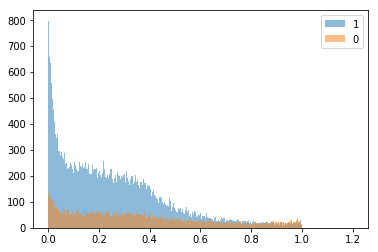

In [80]:
train = pd.concat([X_train, y_train], axis=1)

bins = np.linspace(0, 1.2, 1000)

output_1 = train[train.output==1]
output_0 = train[train.output==0]

plt.hist(output_1['pickup_distance'], bins, alpha=0.5, label='1')
plt.hist(output_0['pickup_distance'], bins, alpha=0.5, label='0')
plt.legend(loc='upper right')
plt.show()

<font color='blue'> rule based, observed higher density of failed trip when pickup_distance > 0.4 from the plot


In [81]:
y_rule = np.where(X_validate['pickup_distance'] > 0.4, 0, 1)
print('accuracy')
print(accuracy_score(y_validate, y_rule))
print('-----------')
print('confusion matrix')
print(confusion_matrix(y_validate, y_rule))

accuracy
0.6840570953855449
-----------
confusion matrix
[[ 6208  9827]
 [11090 39080]]


### ML model ###

**business problem**: predict for each booking order_id, which candidate driver_id is more likely to complete trip <br>
**logistics regression** is used for modelling: able to predict probability of completing trip, rank candidate driver based on calculated probability, allocate to the highest

#### default

In [82]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_lr = lr.predict(X_validate)

print('accuracy')
print(accuracy_score(y_validate, y_lr))
print('-----------')
print('confusion matrix')
print(confusion_matrix(y_validate, y_lr))

accuracy
0.7817687485839439
-----------
confusion matrix
[[ 3572 12463]
 [ 1985 48185]]


<font color='blue'> LR has higher accuracy than rule based model, but also higher false positive 

#### parameter tuning

In [83]:
penalty_solver_pair = [('l1', 'liblinear'), ('l1', 'saga'), ('l2', 'newton-cg'), ('l2', 'lbfgs'), ('l2', 'sag'),
                       ('l2', 'saga')]

class_weight_list = ['balanced', None]
for pair in penalty_solver_pair:
    for class_weight in class_weight_list:
        penalty = pair[0]
        solver = pair[1]
        clf = LogisticRegression(random_state=42, penalty=penalty, solver=solver, class_weight=class_weight)
        scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
        print("Accuracy: %0.8f, penalty: %s, solver: %s, class_weight: %s" % (scores.mean(), penalty, solver, class_weight))

Accuracy: 0.70037199, penalty: l1, solver: liblinear, class_weight: balanced
Accuracy: 0.78100774, penalty: l1, solver: liblinear, class_weight: None
Accuracy: 0.64687707, penalty: l1, solver: saga, class_weight: balanced
Accuracy: 0.78383399, penalty: l1, solver: saga, class_weight: None
Accuracy: 0.70038694, penalty: l2, solver: newton-cg, class_weight: balanced
Accuracy: 0.78101771, penalty: l2, solver: newton-cg, class_weight: None
Accuracy: 0.70040688, penalty: l2, solver: lbfgs, class_weight: balanced
Accuracy: 0.78100774, penalty: l2, solver: lbfgs, class_weight: None
Accuracy: 0.64734063, penalty: l2, solver: sag, class_weight: balanced
Accuracy: 0.78456673, penalty: l2, solver: sag, class_weight: None
Accuracy: 0.65036129, penalty: l2, solver: saga, class_weight: balanced
Accuracy: 0.78614190, penalty: l2, solver: saga, class_weight: None


#### train final model

In [100]:
lr_final = LogisticRegression(random_state=42, solver='saga', penalty = 'l2')
lr_final.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

#### apply model to test data

transform test data

In [105]:
test['pickup_distance'] = test.apply(cal_dist, axis=1)
test['is_peak'] = test.apply(is_peak, axis=1)
test = pd.merge(test, failed, on='driver_id', how='left').fillna(0)
test = pd.merge(test, completed, on='driver_id', how='left').fillna(0)
X_test = test[x_cols]

In [106]:
test.head()

,order_id,driver_id,event_timestamp,trip_distance,pickup_latitude,pickup_longitude,driver_latitude,driver_longitude,driver_gps_accuracy,pickup_distance,is_peak,total_failed,total_completed
0,100042151807,137117322088,2015-05-20 00:59:37.049000+00:00,3.632,-2.965536,104.744296,-2.963353,104.742086,13.653,0.344469,1,4.0,23.0
1,100042151807,282897339267,2015-05-20 00:59:37.049000+00:00,3.632,-2.965536,104.744296,-2.965061,104.745766,3.000,0.171743,1,5.0,35.0
2,100042151807,317503731945,2015-05-20 00:59:37.049000+00:00,3.632,-2.965536,104.744296,-2.965304,104.748621,3.329,0.481516,1,0.0,14.0
3,100042151807,407392911299,2015-05-20 00:59:37.049000+00:00,3.632,-2.965536,104.744296,-2.967921,104.740048,11.954,0.540894,1,9.0,28.0
4,100042151807,493239186093,2015-05-20 00:59:37.049000+00:00,3.632,-2.965536,104.744296,-2.966512,104.748142,13.200,0.441037,1,5.0,37.0


calculate probability of each candidate driver, choose the one with **highest p**

In [109]:
y_prob = pd.DataFrame(lr_final.predict_proba(X_test)).rename(columns={1: 'prob'})['prob']
test_df = pd.concat([test, y_prob], axis=1)

idx = test_df.groupby(['order_id'])['prob'].transform(max) == test_df['prob']
result = test_df[idx][['order_id', 'driver_id']]

print('final output count: %s' % len(result))

final output count: 10000


In [115]:
result.to_csv('../models/phase22.csv', index=False)